In [3]:
import pandas as pd
import numpy as np
from scipy.special import sph_harm
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

### Import all nearest neighbour data

In [4]:
sanns_data_path = "/Users/georgesmyridis/Desktop/Trading/ModSim/StructDet/data/sanns_data/"
sanns_csv_path = sanns_data_path + "csvs/"
files = [file for file in os.listdir(sanns_csv_path) if file.endswith('.csv')]
num_particles = len(files)

### Calculate Bond Order Parameters (BOPs)_lm

The formula for the calculation of the BOPs is
$$q_{lm}(i) = \frac1{|N_b(i)|}\sum_{j\in N_b(i)}Y_l^m(\theta_{ij}, \phi_{ij})$$
with $N_b(i)$ being the set of solid angle nearest neighbours (SANNs) of the particle $i$, and $|N_b(i)|$ is its length.

In [58]:
lmax = 8

#PROGRESS VARIABLES
progress_counter = 0
STEPS_MAX = num_particles * lmax * (lmax + 3)/2

#DATA WE WILL KEEP
sanns_ids = {}
q_lm = {}

for idx in range(num_particles):
    #IMPORT SANNS DATA
    sa = pd.read_csv(sanns_csv_path + "sanns_" + str(idx) + ".csv")
    
    #CALCULATE SPHERICAL HARMONICS
    for l in range(1,lmax + 1):
        for m in range(l + 1):
            clear_output(wait=True)
            sa[(f"({l},{m})")] = sph_harm(m, l, sa.phi.values, sa.theta.values)
            sa[(f"({l},{-m})")] = sph_harm(-m, l, sa.phi.values, sa.theta.values)

            #OUTPUT PROGRESS
            progress = 100 * progress_counter / STEPS_MAX
            print(f"Progress: {progress: .1f} %")
            progress_counter += 1
    
    #CALCULATE AND KEEP THE DATA WE ARE INTERESTED IN: IDs AND Q_LM
    num_neighbours = sa.shape[0]
    key = f"sanns_{idx}"
    sanns_ids[key] = sa.id
    q_lm[key] = sa.drop(columns = ["id", "distance", "theta", "phi"]).sum().div(num_neighbours)

#TURN THEM INTO DATAFRAMES
sanns_ids = pd.DataFrame(sanns_ids)
q_lm = pd.DataFrame(q_lm)

#SAVE THE DATAFRAMES
sanns_ids.to_csv("data/sanns_ids.csv", index = True)
q_lm.to_csv("data/q_lm.csv", index = True)

FileNotFoundError: [Errno 2] No such file or directory: '/data/sanns_ids.csv'

### Calculate Averaged Bond Order Parameters (ABOPs)_lm

The ABOPs are given by the formula:
$$\bar{q}_{lm}(i) = \frac1{|N_b(i)|+1}\sum_{k\in\{i,N_b(i)\}}q_{lm}(k)$$

In [59]:
aq_lm = {}

for idx in range(num_particles):
    
    #COLLECT IDS OF NEIGHBOURS AND ADD THE ID OF THE PARTICLES ITSELF
    nnns_ids = sanns_ids[f'sanns_{idx}'].dropna().astype(int).tolist()
    num_neighbours = len(nnns_ids)
    nnns_ids.append(idx)
    #GET COLUMN NAMES
    nnns_ids = [f"sanns_{id}" for id in nnns_ids]
    
    #CALCULATE AVERAGE q_lm: ADD q_lm FOR ALL NEIGHBOURS AND DIVIDE BY NUMBER OF NEIGH...
    aq_lm[f"sanns_{idx}"] = q_lm[nnns_ids].sum(axis = 1).div(num_neighbours + 1)

#TURN TO DATAFRAME
aq_lm = pd.DataFrame(aq_lm)
aq_lm.to_csv("data/aq_lm.csv", index = True)
# display(aq_lm)

### Calculate the absolute value of the (ABOPs)_lm

$$\bar{q}_l(i) = \sqrt{\frac{4\pi}{2l+1}\sum_{m=-l}^l|\bar{q}_{lm}(i)|^2}$$

In [60]:
aq_lm2 = abs(aq_lm) ** 2
aq_lm2['lm'] = aq_lm2.index
aq_lm2['l'] = aq_lm2['lm'].str.extract(r'\((\d+),').astype(int)
aq_lm2 = aq_lm2.drop('lm', axis = 1)
display(aq_lm2)

,sanns_0,sanns_1,sanns_2,sanns_3,sanns_4,sanns_5,sanns_6,sanns_7,sanns_8,sanns_9,...,sanns_1363,sanns_1364,sanns_1365,sanns_1366,sanns_1367,sanns_1368,sanns_1369,sanns_1370,sanns_1371,l
"(1,0)",0.000025,0.000001,0.000016,0.000008,0.000058,0.000107,0.000019,0.000104,0.000004,0.000022,...,0.000030,0.000013,0.000002,0.000068,0.000016,0.000045,0.000015,0.000004,9.268637e-05,1
"(1,1)",0.000028,0.000034,0.000073,0.000029,0.000016,0.000021,0.000104,0.000008,0.000018,0.000030,...,0.000039,0.000011,0.000131,0.000032,0.000042,0.000001,0.000004,0.000005,1.187083e-05,1
"(1,-1)",0.000028,0.000034,0.000073,0.000029,0.000016,0.000021,0.000104,0.000008,0.000018,0.000030,...,0.000039,0.000011,0.000131,0.000032,0.000042,0.000001,0.000004,0.000005,1.187083e-05,1
"(2,0)",0.000013,0.000043,0.000119,0.000006,0.000053,0.000151,0.000493,0.000021,0.000043,0.000130,...,0.000067,0.000004,0.000008,0.000153,0.000009,0.000007,0.000089,0.000152,6.253272e-08,2
"(2,1)",0.000046,0.000059,0.000005,0.000121,0.000183,0.000063,0.000154,0.000148,0.000086,0.000066,...,0.000010,0.000078,0.000069,0.000121,0.000153,0.000021,0.000018,0.000002,2.095454e-05,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(8,-6)",0.000508,0.001438,0.000782,0.001937,0.002539,0.000471,0.001164,0.001992,0.001537,0.000231,...,0.001074,0.000921,0.001044,0.000682,0.000147,0.001272,0.000001,0.000957,8.653249e-05,8
"(8,7)",0.000960,0.000060,0.000790,0.001021,0.000910,0.000773,0.000229,0.000746,0.000285,0.000157,...,0.001083,0.000410,0.000301,0.000200,0.000122,0.000723,0.000023,0.001151,1.291499e-03,8
"(8,-7)",0.000960,0.000060,0.000790,0.001021,0.000910,0.000773,0.000229,0.000746,0.000285,0.000157,...,0.001083,0.000410,0.000301,0.000200,0.000122,0.000723,0.000023,0.001151,1.291499e-03,8
"(8,8)",0.007911,0.003406,0.004485,0.004659,0.004851,0.009103,0.010117,0.007312,0.007194,0.011257,...,0.003761,0.002315,0.001383,0.005223,0.002471,0.005424,0.003176,0.006428,4.768656e-03,8


In [61]:
bops_l = aq_lm2.groupby(aq_lm2['l']).sum()
display(bops_l)

,sanns_0,sanns_1,sanns_2,sanns_3,sanns_4,sanns_5,sanns_6,sanns_7,sanns_8,sanns_9,...,sanns_1362,sanns_1363,sanns_1364,sanns_1365,sanns_1366,sanns_1367,sanns_1368,sanns_1369,sanns_1370,sanns_1371
l,,,,,,,,,,,,,,,,,,,,,
1,0.000081,0.000069,0.000163,0.000067,0.000089,0.000148,0.000226,0.000121,0.000041,0.000082,...,0.000136,0.000109,0.000036,0.000264,0.000133,0.000101,0.000047,0.000023,0.000015,0.000116
2,0.000149,0.000174,0.000164,0.000354,0.000665,0.000291,0.000835,0.000423,0.000249,0.000285,...,0.000090,0.000327,0.000258,0.000178,0.000438,0.000325,0.000079,0.000144,0.000210,0.000408
3,0.000305,0.000306,0.000367,0.000377,0.000338,0.000327,0.000204,0.000367,0.000178,0.000549,...,0.000214,0.000197,0.000080,0.000254,0.000400,0.000535,0.000346,0.000133,0.000480,0.000232
4,0.002797,0.001267,0.002447,0.003745,0.002704,0.002173,0.001536,0.002363,0.001340,0.002557,...,0.002130,0.002574,0.002290,0.001555,0.002069,0.001277,0.001145,0.001203,0.000666,0.001316
5,0.000865,0.002437,0.002419,0.001708,0.002370,0.000822,0.002542,0.003224,0.002306,0.001963,...,0.003751,0.001205,0.002107,0.002769,0.001760,0.001311,0.001689,0.000619,0.000624,0.001704
6,0.072702,0.037503,0.053291,0.060179,0.059892,0.064113,0.077946,0.074299,0.053706,0.083576,...,0.048913,0.053717,0.046437,0.049257,0.046167,0.046382,0.040268,0.049617,0.048689,0.040897
7,0.004642,0.007184,0.005376,0.002732,0.007692,0.003259,0.007583,0.002170,0.006480,0.009399,...,0.009057,0.006088,0.002404,0.013790,0.004616,0.006805,0.006972,0.002762,0.004184,0.005363
8,0.060014,0.031158,0.044981,0.040488,0.040023,0.045374,0.052834,0.045258,0.034940,0.052393,...,0.039939,0.028464,0.021611,0.017372,0.027439,0.022288,0.023056,0.019897,0.032788,0.026735


In [62]:
bops_l['l'] = bops_l.index
bops_l = bops_l.apply(lambda row: row * 4 * np.pi / (2 * row['l'] + 1), axis = 1)
bops_l = bops_l.drop('l', axis = 1)
bops_l = bops_l.apply(np.sqrt)

display(bops_l)

,sanns_0,sanns_1,sanns_2,sanns_3,sanns_4,sanns_5,sanns_6,sanns_7,sanns_8,sanns_9,...,sanns_1362,sanns_1363,sanns_1364,sanns_1365,sanns_1366,sanns_1367,sanns_1368,sanns_1369,sanns_1370,sanns_1371
l,,,,,,,,,,,,,,,,,,,,,
1,0.018376,0.017016,0.026090,0.016771,0.019349,0.024936,0.030738,0.022474,0.013026,0.018501,...,0.023865,0.021399,0.012301,0.033226,0.023624,0.020530,0.014098,0.009840,0.007934,0.022084
2,0.019325,0.020919,0.020279,0.029835,0.040892,0.027044,0.045799,0.032620,0.025001,0.026751,...,0.015067,0.028661,0.025467,0.021177,0.033178,0.028598,0.014056,0.018998,0.022959,0.032031
3,0.023401,0.023430,0.025676,0.026005,0.024645,0.024216,0.019128,0.025665,0.017898,0.031382,...,0.019592,0.018806,0.011952,0.021355,0.026814,0.030992,0.024921,0.015425,0.029369,0.020427
4,0.062490,0.042065,0.058447,0.072307,0.061446,0.055084,0.046309,0.057439,0.043254,0.059751,...,0.054539,0.059946,0.056545,0.046592,0.053750,0.042233,0.039989,0.040992,0.030485,0.042860
5,0.031428,0.052760,0.052569,0.044167,0.052032,0.030641,0.053883,0.060687,0.051328,0.047351,...,0.065462,0.037103,0.049064,0.056238,0.044837,0.038705,0.043932,0.026583,0.026697,0.044126
6,0.265099,0.190399,0.226965,0.241189,0.240612,0.248946,0.274493,0.267993,0.227848,0.284233,...,0.217443,0.227870,0.211868,0.218206,0.211251,0.211742,0.197294,0.219003,0.216944,0.198829
7,0.062360,0.077578,0.067110,0.047837,0.080277,0.052248,0.079703,0.042635,0.073678,0.088737,...,0.087109,0.071416,0.044874,0.107482,0.062185,0.075504,0.076423,0.048103,0.059202,0.067026
8,0.210623,0.151763,0.182344,0.173000,0.172003,0.183140,0.197624,0.182907,0.160709,0.196797,...,0.171822,0.145054,0.126392,0.113321,0.142419,0.128357,0.130548,0.121276,0.155681,0.140578


In [63]:
bops_l.to_csv('data/BOPs.csv', index=True)

## Implementation

In [19]:
def getBOPs(phase, number, step):
    
    ###### FIND ALL THE RELEVANT FILES
    sanns_path = "/Users/georgesmyridis/Desktop/Trading/ModSim/StructDet/data/sanns_data/csvs/"
    sanns_csv_path = sanns_path + phase + "s/" + phase + str(number) + "/step" + str(step) +"/"
    save_path = "data/" + phase + str(number) + str(step) + "_"
    files = [file for file in os.listdir(sanns_csv_path) if file.endswith('.csv')]
    num_particles = len(files)
    print("Number of particles:", num_particles)

    
    ###### CALCULATE ALL BON ORDER PARAMETERS (BOPs)_lm
    
    lmax = 8

    #PROGRESS VARIABLES
    progress_counter = 0
    STEPS_MAX = num_particles * lmax * (lmax + 3)/2

    #DATA WE WILL KEEP
    sanns_ids = {}
    q_lm = {}

    for idx in range(num_particles):
        #IMPORT SANNS DATA
        sa = pd.read_csv(sanns_csv_path + "sanns_" + str(idx) + ".csv")

        #CALCULATE SPHERICAL HARMONICS
        for l in range(1,lmax + 1):
            for m in range(l + 1):
                clear_output(wait=True)
                sa[(f"({l},{m})")] = sph_harm(m, l, sa.phi.values, sa.theta.values)
                sa[(f"({l},{-m})")] = sph_harm(-m, l, sa.phi.values, sa.theta.values)

                #OUTPUT PROGRESS
                progress = 100 * progress_counter / STEPS_MAX
                print(f"Calculating BOPs for {phase + str(number) + str(step)}")
                print(f"Progress: {progress: .1f} %")
                progress_counter += 1

        #CALCULATE AND KEEP THE DATA WE ARE INTERESTED IN: IDs AND Q_LM
        num_neighbours = sa.shape[0]
        key = f"sanns_{idx}"
        sanns_ids[key] = sa.id
        q_lm[key] = sa.drop(columns = ["id", "distance", "theta", "phi"]).sum().div(num_neighbours)

    #TURN THEM INTO DATAFRAMES
    sanns_ids = pd.DataFrame(sanns_ids)
    q_lm = pd.DataFrame(q_lm)

#     display(q_lm)

    #SAVE THE DATAFRAMES
    sanns_ids.to_csv(save_path + "sanns_ids.csv", index = True)
    q_lm.to_csv(save_path + "q_lm.csv", index = True)
    
    
    ###### CALCULATE THE AVERAGE BOND ORDER PARAMETERS (ABOPs)_lm
    
    aq_lm = {}

    for idx in range(num_particles):

        #COLLECT IDS OF NEIGHBOURS AND ADD THE ID OF THE PARTICLES ITSELF
        nnns_ids = sanns_ids[f'sanns_{idx}'].dropna().astype(int).tolist()
        num_neighbours = len(nnns_ids)
        nnns_ids.append(idx)
        #GET COLUMN NAMES
        nnns_ids = [f"sanns_{id}" for id in nnns_ids]

        #CALCULATE AVERAGE q_lm: ADD q_lm FOR ALL NEIGHBOURS AND DIVIDE BY NUMBER OF NEIGH...
        aq_lm[f"sanns_{idx}"] = q_lm[nnns_ids].sum(axis = 1).div(num_neighbours + 1)

    #TURN TO DATAFRAME
    aq_lm = pd.DataFrame(aq_lm)
    aq_lm.to_csv(save_path + "aq_lm.csv", index = True)
    # display(aq_lm)

    ##### CALCULATE THE ABSOLUTE VALUES
    
    aq_lm2 = abs(aq_lm) ** 2
    aq_lm2['lm'] = aq_lm2.index
    aq_lm2['l'] = aq_lm2['lm'].str.extract(r'\((\d+),').astype(int)
    aq_lm2 = aq_lm2.drop('lm', axis = 1)
#     display(aq_lm2)
    
    bops_l = aq_lm2.groupby(aq_lm2['l']).sum()
#     display(bops_l)
    
    bops_l['l'] = bops_l.index
    bops_l = bops_l.apply(lambda row: row * 4 * np.pi / (2 * row['l'] + 1), axis = 1)
    bops_l = bops_l.drop('l', axis = 1)
    bops_l = bops_l.apply(np.sqrt)
    
    bops_l.to_csv(save_path + 'BOPs.csv', index=True)

    return bops_l

### All data

In [27]:
bops = {}
for phase in ["fcc", "fluid"]:
    for number in [1,2]:
        for step in [30,40,50]:
            bops[phase + str(number) + str(step)] = getBOPs(phase, number, step)
            
arrays = []
for df in bops.values():
    arrays.append(df.values)
all_bops = np.hstack(arrays)
np.savetxt('all_bops.csv', all_bops, delimiter=',')

Calculating BOPs for fluid250
Progress:  100.0 %


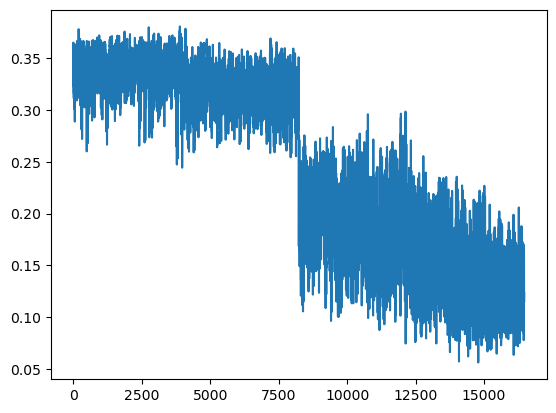

In [29]:
plt.plot(all_bops[7,:])
plt.show()

### Training Set

In [23]:
bops_train = {}
for phase in ["fcc", "fluid"]:
    for step in [30,40,50]:
        number = 1
        bops_train[phase + str(number) + str(step)] = getBOPs(phase, number, step)

Calculating BOPs for fluid150
Progress:  100.0 %


In [24]:
arrays = []
for df in bops_train.values():
    arrays.append(df.values)
all_bops_train = np.hstack(arrays)
np.savetxt('bops_train.csv', all_bops_train, delimiter=',')

In [25]:
df_bops = pd.read_csv('bops_train.csv', header = None)
display(df_bops)

,0,1,2,3,4,5,6,7,8,9,...,8222,8223,8224,8225,8226,8227,8228,8229,8230,8231
0,0.015088,0.011441,0.008684,0.007015,0.008775,0.014358,0.013308,0.012628,0.006228,0.011652,...,0.022464,0.018147,0.014686,0.016064,0.012952,0.014148,0.012132,0.020141,0.012558,0.011732
1,0.021575,0.027810,0.008036,0.015563,0.008609,0.008682,0.017500,0.022203,0.019503,0.014754,...,0.013849,0.024912,0.031505,0.014031,0.024043,0.026816,0.018406,0.018770,0.019844,0.029761
2,0.009389,0.010701,0.012135,0.015390,0.011229,0.012074,0.007491,0.013424,0.008186,0.015074,...,0.018666,0.018801,0.014936,0.020175,0.029165,0.014955,0.017281,0.018348,0.014742,0.016301
3,0.114729,0.107343,0.129847,0.113619,0.131508,0.103052,0.141064,0.103720,0.133362,0.114975,...,0.064229,0.053577,0.076205,0.059883,0.065630,0.053290,0.053083,0.049647,0.055769,0.050126
4,0.024568,0.023084,0.027421,0.040279,0.036652,0.022014,0.032264,0.029450,0.026532,0.046966,...,0.024491,0.041606,0.027389,0.033395,0.034369,0.033218,0.051114,0.028623,0.054699,0.040726
5,0.455856,0.456801,0.488366,0.443380,0.473870,0.429091,0.470595,0.417990,0.451499,0.427073,...,0.264179,0.222174,0.313930,0.290084,0.323404,0.288694,0.275029,0.257093,0.256471,0.226190
6,0.043108,0.040072,0.047649,0.066360,0.056860,0.029161,0.039187,0.051655,0.040765,0.075338,...,0.089112,0.068815,0.053385,0.062665,0.049951,0.045712,0.059959,0.067081,0.054059,0.068095
7,0.356313,0.362384,0.365040,0.339593,0.350782,0.334191,0.336000,0.322800,0.324506,0.325464,...,0.181146,0.173126,0.219360,0.223559,0.241331,0.206552,0.190577,0.205071,0.190086,0.156469


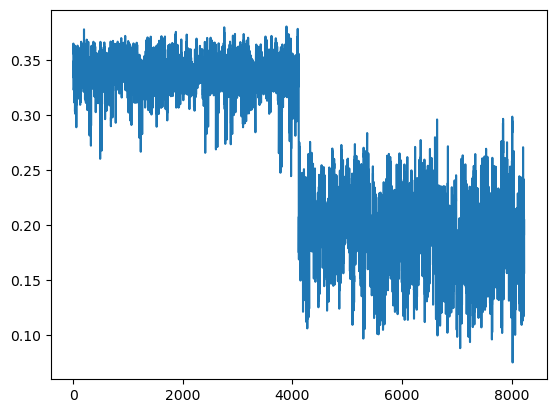

In [15]:
plt.plot(all_bops_train[7,:])

### Testing Set

In [21]:
bops_test_fcc = {}    
number = 2
phase = 'fcc'
for step in [30,40,50]:
    bops_test_fcc[phase + str(number) + str(step)] = getBOPs(phase, number, step)
        
arrays = []
for df in bops_test_fcc.values():
    arrays.append(df.values)
bops_test_fcc = np.hstack(arrays)
np.savetxt('bops_test_fcc.csv', bops_test_fcc, delimiter=',')

df_bops_test_fcc = pd.read_csv('bops_test_fcc.csv', header = None)
display(df_bops_test_fcc)

Calculating BOPs for fcc250
Progress:  100.0 %


,0,1,2,3,4,5,6,7,8,9,...,4106,4107,4108,4109,4110,4111,4112,4113,4114,4115
0,0.010367,0.016839,0.007466,0.013117,0.012147,0.021079,0.012642,0.025125,0.011832,0.024077,...,0.012949,0.020707,0.013805,0.024286,0.010278,0.017902,0.010813,0.010031,0.016419,0.022992
1,0.029662,0.031832,0.023242,0.016277,0.016664,0.018073,0.025770,0.016440,0.018352,0.015201,...,0.019992,0.014554,0.009311,0.016959,0.011769,0.010105,0.019360,0.023825,0.018950,0.015981
2,0.014678,0.013100,0.010109,0.019973,0.020241,0.012143,0.016388,0.022607,0.015396,0.012610,...,0.016913,0.018413,0.010665,0.011100,0.013650,0.018670,0.009848,0.013717,0.015735,0.014611
3,0.129902,0.097086,0.106251,0.097115,0.114638,0.095987,0.125449,0.110935,0.118517,0.136039,...,0.097272,0.101249,0.089540,0.094332,0.104833,0.091201,0.092975,0.096019,0.082069,0.095067
4,0.031428,0.036800,0.030290,0.038187,0.025589,0.040904,0.031448,0.033008,0.029599,0.043846,...,0.042769,0.042872,0.033685,0.036857,0.016075,0.036179,0.042456,0.030098,0.034217,0.028504
5,0.432862,0.400470,0.409914,0.404854,0.425547,0.408200,0.421355,0.416358,0.428024,0.445715,...,0.399217,0.411535,0.401898,0.404805,0.421014,0.423812,0.422437,0.429903,0.403891,0.428274
6,0.058537,0.058271,0.043679,0.061869,0.037590,0.056842,0.054536,0.036477,0.047850,0.074384,...,0.055709,0.061434,0.054930,0.037636,0.028791,0.061088,0.060941,0.053707,0.055180,0.032027
7,0.301745,0.315724,0.305020,0.309339,0.306893,0.316029,0.300815,0.308149,0.313070,0.309749,...,0.295153,0.303888,0.312545,0.311545,0.326949,0.346906,0.342214,0.350919,0.333028,0.347537


In [22]:
bops_test_fluid = {}    
number = 2
phase = 'fluid'
for step in [30,40,50]:
    bops_test_fluid[phase + str(number) + str(step)] = getBOPs(phase, number, step)
        
arrays = []
for df in bops_test_fluid.values():
    arrays.append(df.values)
bops_test_fluid = np.hstack(arrays)
np.savetxt('bops_test_fluid.csv', bops_test_fluid, delimiter=',')

df_bops_test_fluid = pd.read_csv('bops_test_fluid.csv', header = None)
display(df_bops_test_fluid)

Calculating BOPs for fluid250
Progress:  100.0 %


,0,1,2,3,4,5,6,7,8,9,...,4106,4107,4108,4109,4110,4111,4112,4113,4114,4115
0,0.007327,0.022929,0.030036,0.021310,0.022435,0.035160,0.015592,0.025756,0.020980,0.022196,...,0.016400,0.013701,0.017407,0.021171,0.010898,0.025144,0.023711,0.014660,0.007447,0.013771
1,0.030844,0.018110,0.020661,0.018047,0.024651,0.026357,0.023662,0.015701,0.027459,0.035235,...,0.025229,0.035571,0.021757,0.024392,0.016024,0.008709,0.018759,0.026881,0.025961,0.021973
2,0.014129,0.014968,0.018795,0.015173,0.030128,0.019706,0.021303,0.019056,0.020423,0.023065,...,0.026394,0.024790,0.031689,0.022609,0.029487,0.025731,0.017381,0.031142,0.030801,0.022057
3,0.058092,0.061692,0.064488,0.045556,0.050588,0.051875,0.041428,0.036241,0.024806,0.044737,...,0.045634,0.037989,0.056437,0.032438,0.045636,0.050939,0.016501,0.038410,0.031849,0.040476
4,0.035107,0.042725,0.051030,0.044183,0.039468,0.054638,0.054481,0.042334,0.050875,0.045796,...,0.030515,0.032941,0.046456,0.046175,0.038117,0.039326,0.046104,0.054673,0.060698,0.073273
5,0.265519,0.199180,0.226787,0.226117,0.235544,0.218950,0.182358,0.232160,0.202926,0.186249,...,0.125639,0.125661,0.101816,0.073295,0.104288,0.137439,0.146561,0.118130,0.128448,0.153729
6,0.068229,0.056784,0.054522,0.062893,0.046743,0.036586,0.049008,0.057388,0.050324,0.061381,...,0.060469,0.079617,0.065851,0.049162,0.055404,0.069250,0.066255,0.056600,0.040579,0.072979
7,0.192764,0.170104,0.188632,0.184581,0.190262,0.157861,0.125268,0.176342,0.129667,0.102865,...,0.149945,0.130404,0.158184,0.139799,0.138636,0.136563,0.114444,0.121153,0.114844,0.123425


In [26]:
num_particles

0